# Demo:  Prostate Cancer Analysis with LASSO

In this demo, we illustrate the classic technique of LASSO regularization for model selection.  You will learn to:
* Fit a LASSO model using the `sklearn` package
* Determine the regularization level with cross-validation
* Draw the coefficient path as a function of the regularization level

We use a classic prostate cancer dataset from the paper:

> Stamey, Thomas A., et al. "[Prostate specific antigen in the diagnosis and treatment of adenocarcinoma of the prostate. II. Radical prostatectomy treated patients](http://www.sciencedirect.com/science/article/pii/S002253471741175X)." The Journal of urology 141.5 (1989): 1076-1083.

In the study, the level of [prostate specific antigen](https://en.wikipedia.org/wiki/Prostate-specific_antigen) was measured in 102 men before they had a prostatectomy. Elevated values of the PSA are believed to be associated with the presence of prostate cancer and other disorders. To study this hypothesis, various features of the prostate were measured after the prostatectomy.  Data analysis is then used to understand the relation between the PSA level and prostate features.  The study is old and much more is known about PSA today.  But, the analysis is typical for medical problems and illustrates the basic tools well.

The specific analysis presented in this demo taken from the class text: 

> Friedman, Jerome, Trevor Hastie, and Robert Tibshirani. [Elements of statistical learning](https://www.amazon.com/exec/obidos/ASIN/0387952845/trevorhastie-20), New York: Springer series in statistics, 2001.

The text provides an excellent discussion of LASSO and other methods on this dataset.

First, we load the regular packages.

In [135]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Loading the Data

Our analysis begins by getting the data from Tibshirani's website.   

In [136]:
# Get data
url = 'https://web.stanford.edu/~hastie/ElemStatLearn/datasets/prostate.data'
df = pd.read_csv(url, sep='\t', header=0)
df = df.drop('Unnamed: 0', axis=1)   # skip the column of indices

In this data set, the target variable is `lpsa`, the log of the PSA. The goal is to try  to predict the `lpsa` from various prostate features.

In [137]:
# Print the names of the target and predictor
names = df.columns.tolist()
names_x = names[0:7]
name_y = names[8]
print("Target variable: %s" % name_y)
print("Predictors:     "+str(names_x))

# Convert the dataframe values to data matrices
X0 = np.array(df[names_x])
y0 = np.array(df[name_y])

# Print the number of samples and features
nsamp = X0.shape[0]
nfeatures = X0.shape[1]
print("")
print("num samples = %d,  num features = %d" % (nsamp, nfeatures))

Target variable: lpsa
Predictors:     ['lcavol', 'lweight', 'age', 'lbph', 'svi', 'lcp', 'gleason']

num samples = 97,  num features = 7


When performing any regularized estimate, it is critical to standardize the values.  For this purpose, we use `sklearn` built-in `scale` command.

In [138]:
import sklearn.preprocessing

X = sklearn.preprocessing.scale(X0)
y = sklearn.preprocessing.scale(y0)


## Fit a linear model with no regularization

First, we try to fit a multiple linear model with no regularization.  We begin by importing the appropriate package.

In [139]:
from sklearn import linear_model

We next split the data into training and test -- will use roughly half the samples for each.

In [140]:
ns_train = nsamp // 2
ns_test = nsamp - ns_train
X_tr = X[:ns_train,:]     # Gets the first ns_train rows of X
y_tr = y[:ns_train]       # Gets the correspoinding rows of y

print("num samples train = %d, test = %d" % (ns_train, ns_test))

num samples train = 48, test = 49


Fit the model on the training data.

In [141]:
regr = linear_model.LinearRegression()
regr.fit(X_tr,y_tr)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Now, we can measure the normalized RSS on the training data and plot the actual vs. predicted values.  

Normalized training RSS=0.497834


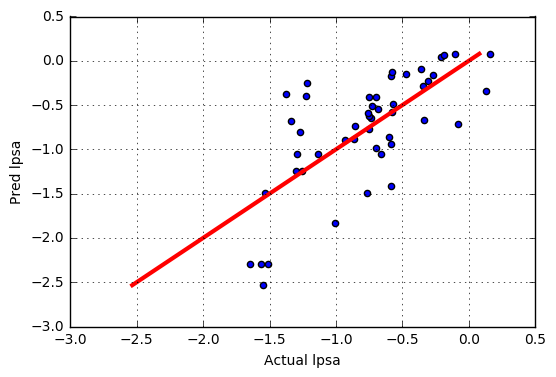

In [142]:
# Measure normalized RSS
y_tr_pred = regr.predict(X_tr)
RSS_tr = np.mean((y_tr_pred-y_tr)**2)/(np.std(y_tr)**2)
print("Normalized training RSS=%f" % RSS_tr)

# Scatter plot
plt.scatter(y_tr_pred, y_tr)
plt.xlabel('Actual lpsa')
plt.ylabel('Pred lpsa')
ymin = np.min(y_tr)
ymax = np.max(y_tr)
plt.plot([ymin,ymax], [ymin,ymax], 'r-', linewidth=3)
plt.grid()
plt.show()

Ths plot shows that the model fits the training data well.  However, we need to evaluate the model on the test data.  We first compute the normalized RSS.

In [143]:
X_ts = X[ns_train:,:]
y_ts = y[ns_train:]
y_ts_pred = regr.predict(X_ts)
RSS_rel_ts = np.mean((y_ts_pred-y_ts)**2)/(np.std(y_ts)**2)
print("Normalized test RSS = {0:f}".format(RSS_rel_ts))

Normalized test RSS = 4.539225


We see that the normalized RSS is very high.  In fact, since RSS > 1, it means that that the linear model was *worse* than using no model at all!  We see the terrible prediction in the scatter plot too.

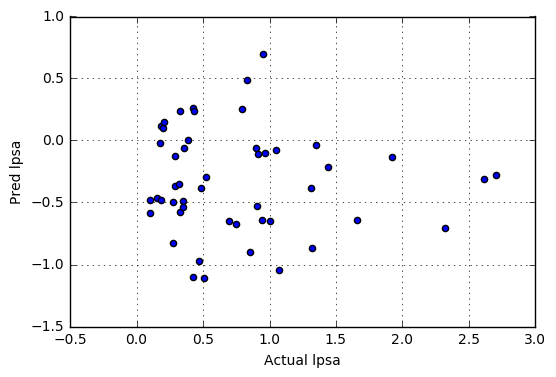

In [144]:
plt.scatter(y_ts,y_ts_pred)
plt.xlabel('Actual lpsa')
plt.ylabel('Pred lpsa')
plt.grid()
plt.show()

## LASSO:  Linear Model with l1 Regularization

The failure of the linear model motivates us to use regularization to try to select only the "useful" features.  We will demonstrate how to use the Lasso technique.  The `sklearn` package has several excellent routines for this.  We first import the `model_selection` sub-package for the k-fold cross validation.

In [145]:
import  sklearn.model_selection 

When considering the LASSO, we consider a set of models with different levels of regularization `alpha`.  Higher values of `alpha` imply greater regularization.  Similar to the [polynomial example](./polyfit.ipynb), we use k-fold cross validation to determine the appropriate `alpha`.  That is, for each `alpha` value, we evaluate the test error on different training / tests spilt.   For larger data sets, this exhaustive search is time-consuming.  But, it should finish very fast for this small set. 

In [146]:
# Create a k-fold cross validation object
nfold = 10
kf = sklearn.model_selection.KFold(n_splits=nfold,shuffle=True)

# Create the LASSO model.  We use the `warm start` parameter so that the fit will start at the previous value.
# This speeds up the fitting.
model = linear_model.Lasso(warm_start=True)

# Regularization values to test
nalpha = 100
alphas = np.logspace(-3,1,nalpha)

# MSE for each alpha and fold value
mse = np.zeros((nalpha,nfold))
for ifold, ind in enumerate(kf.split(X)):
    
    
    # Get the training data in the split
    Itr,Its = ind
    X_tr = X[Itr,:]
    y_tr = y[Itr]
    X_ts = X[Its,:]
    y_ts = y[Its]
    
    # Compute the lasso path for the split
    for ia, a in enumerate(alphas):
        
        # Fit the model on the training data
        model.alpha = a
        model.fit(X_tr,y_tr)
        
        # Compute the prediction error on the test data
        y_ts_pred = model.predict(X_ts)
        mse[ia,ifold] = np.mean((y_ts_pred-y_ts)**2)

We now plot the test MSE as a function of the regularization parameter.

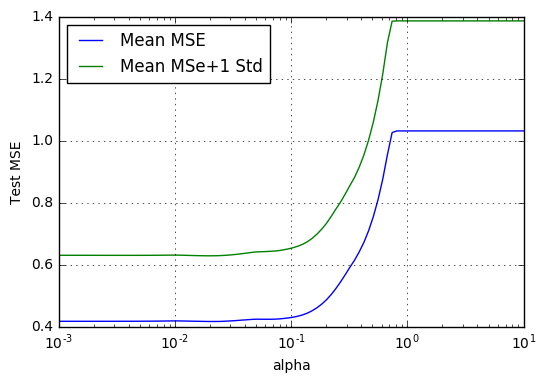

In [147]:
# Compute the mean and standard deviation over the different folds.
mse_mean = np.mean(mse,axis=1)
mse_std = np.std(mse,axis=1)

# Plot the mean MSE and the mean MSE + 1 std dev
plt.semilogx(alphas, mse_mean)
plt.semilogx(alphas, mse_mean+mse_std)
plt.legend(['Mean MSE', 'Mean MSe+1 Std'],loc='upper left')
plt.xlabel('alpha')
plt.ylabel('Test MSE')
plt.grid()
plt.show()

We find the optimal `alpha`, by the following steps:
* Find the `alpha` with the minimum test MSE
* Set `mse_tgt = ` minimum MSE + 1 std dev MSE
* Find the least complex model (highest `alpha`) such that `MSE < mse_tgt`

Optimal alpha = 0.351119


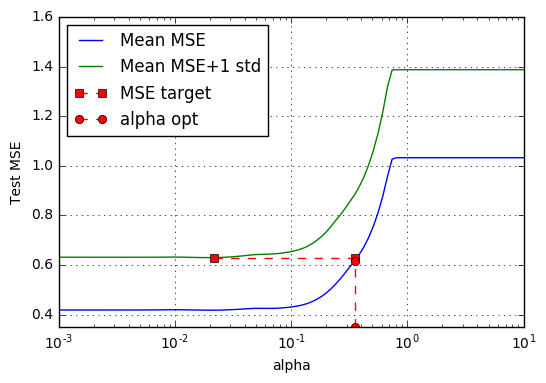

In [148]:
# Find the minimum MSE and MSE target
imin = np.argmin(mse_mean)
mse_tgt = mse_mean[imin] + mse_std[imin]
alpha_min = alphas[imin]

# Find the least complex model with mse_mean < mse_tgt
I = np.where(mse_mean < mse_tgt)[0]
iopt = I[-1]
alpha_opt = alphas[iopt]
print("Optimal alpha = %f" % alpha_opt)

# Plot the mean MSE and the mean MSE + 1 std dev
plt.semilogx(alphas, mse_mean)
plt.semilogx(alphas, mse_mean+mse_std)

# Plot the MSE target
plt.semilogx([alpha_min,alpha_opt], [mse_tgt,mse_tgt], 'rs--')

# Plot the optimal alpha line
plt.semilogx([alpha_opt,alpha_opt], [0.35,mse_mean[iopt]], 'ro--')

plt.legend(['Mean MSE', 'Mean MSE+1 std', 'MSE target','alpha opt'],loc='upper left')
plt.xlabel('alpha')
plt.ylabel('Test MSE')
plt.ylim([0.35,1.6])
plt.grid()
plt.show()


Finally, we recompute the coefficients using all the training data at the correct alpha.  We see that the model selects two non-zero cofficients:  `lcavol` and `svi` (description of the features can be found in  https://rafalab.github.io/pages/649/prostate.html).  These two features are presumably the most relevant in determining the PSA level.

In [149]:
model.alpha = alpha_opt
model.fit(X,y)

# Print the coefficients
for i, c in enumerate(model.coef_):
    print("%8s %f" % (names_x[i], c))

  lcavol 0.376872
 lweight 0.000000
     age 0.000000
    lbph 0.000000
     svi 0.012024
     lcp 0.000000
 gleason 0.000000


## LASSO path

To further illustrate the effect of regularization, we conclude by drawing the *LASSO path*.  This is a simply a plot of the coefficients as a function of the regularization `alpha`.  We do not need to do this for the analysis, but the path demonstrates the effect of regularization well. 


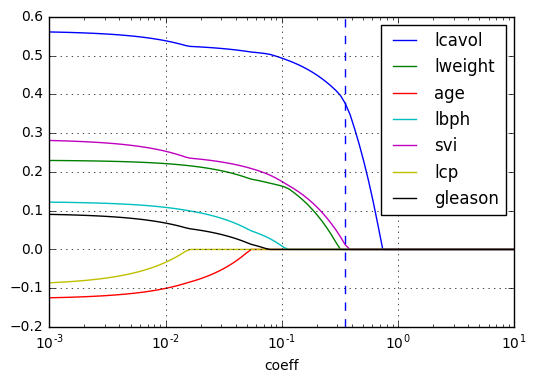

In [150]:
alphas1, coeffs, _ = sklearn.linear_model.lasso_path(X, y, alphas=alphas)

# Plot the paths of the coefficients
plt.semilogx(alphas1,coeffs.T)
plt.grid()
plt.legend(names_x, loc='upper right')


# Plot a line on the optimal alpha
plt.semilogx([alpha_opt,alpha_opt], [-0.2,0.6], '--')
plt.ylim([-0.2,0.6])
plt.xlabel('alpha')
plt.xlabel('coeff')
plt.show()